  The MDSplus python module version ((7, 153, 3)) does not match
  the version of the installed MDSplus libraries (Unknown).
  Upgrade the module using the mdsplus/python/MDSplus directory of the
  MDSplus installation or set PYTHONPATH=/usr/local/mdsplus/python/MDSplus.


data length: 102400 pts
Beam timing detected: 0.4656 s
Showing first 1ms: 0.465597 - 0.466597 s


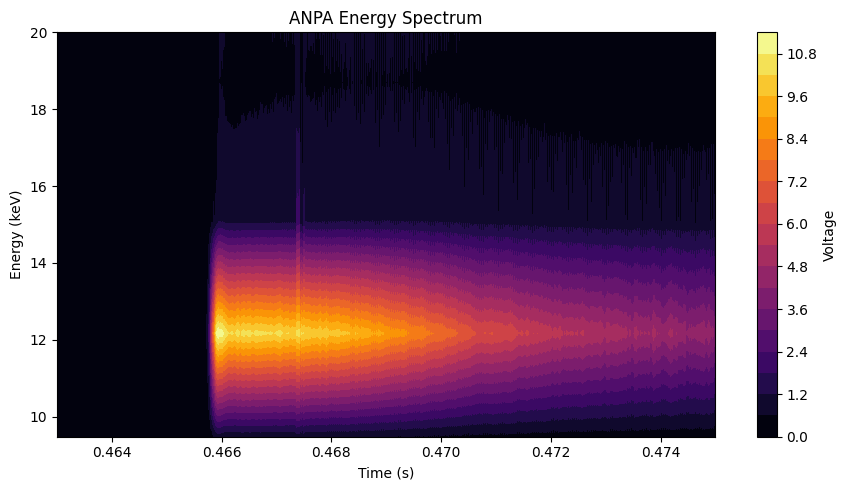

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import importlib.util

# matplotlib.use('TkAgg')  # commented out - not needed in Jupyter notebooks
clrs = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Import MDSplus for data acquisition
spec = importlib.util.spec_from_file_location("MDSplus", "/p/ltxdata/bin/MDSplus/__init__.py")
MDSplus = importlib.util.module_from_spec(spec)
spec.loader.exec_module(MDSplus)


def get_anpa_rawdata(shot, npt=None, cal=False):
    """
    Load CHRONOS inputs 51-60 from MDSplus (wire calorimeter data).

    Parameters
    ----------
    shot : int
        Shot number to load
    npt : int, optional
        Number of time points to load from each channel
    cal : bool, optional
        If True, apply relative calibration factors

    Returns
    -------
    anpa : ndarray, shape (10, npt)
        Raw detector waveforms for CHRONOS inputs 51-60
    t_anpa : ndarray, shape (npt)
        Time array

    Notes
    -----
    Loads CHRONOS digitizer inputs 51-60 instead of ANPA detector channels.
    """

    rel_cal = [0.1, 0.389, 0.56, 1.000, 0.955, 1.177, 1.212, 1.065, 1.106, 0.502]  # calibration factors

    # Connect to MDSplus server
    conn = MDSplus.Connection('lithos.pppl.gov:8000')
    conn.openTree('ltx_b', shot)
    
    # Get first channel to determine data length
    first_node = r'\ltx_b::top.devices.dtacq.chronos:input_51'
    if npt is None:
        npt = len(conn.get(first_node).data())
    print(f'data length: {npt} pts')
    
    anpa = np.zeros((10, npt), dtype=float)

    # loading chronus channels 51-60
    for i in range(10):
        node = rf'\ltx_b::top.devices.dtacq.chronos:input_{51 + i:02d}'
        sig = conn.get(node).data()
        anpa[i, :] = sig[:npt]
    
    # Get time dimension from first channel
    t_anpa = conn.get(f'dim_of({first_node})').data()
    
    conn.closeAllTrees()

    if cal:
        for i in np.arange(10):
            anpa[i, :] /= rel_cal[i]

    return anpa, t_anpa


# Optional: place-holder to add bias compensation later
def apply_bias_compensation(anpa, bias_voltages, calibration_curve):
    """
    Placeholder for bias compensation logic.

    Parameters
    ----------
    anpa : ndarray
        Raw detector data (output of get_anpa_rawdata)
    bias_voltages : array-like, length 20
        Bias voltage applied to each detector during the shot
    calibration_curve : callable or lookup table
        Function G(V) mapping bias voltage to detector gain

    Returns
    -------
    corrected : ndarray
        Bias-corrected detector signals

    Notes
    -----
    You will replace this once you locate your gain calibration function.
    """
    # Example: match all detectors to a reference bias V_ref
    V_ref = np.mean(bias_voltages)

    gain_factors = calibration_curve(V_ref) / calibration_curve(np.array(bias_voltages))[:, None]
    return anpa * gain_factors


def energy_calibration():
    """
    :return:
      energy: peaked energy for each channel (keV)
      low_energy: lower limit of energy for each channel (keV)
      high_energy: upper limit of energy for each channel (keV)
    """
    energy = np.array([11.48, 14.17, 17.11, 20.69, 23.93, 27.23, 30.96, 34.82, 38.70, 43.56])  # H
    three_sigma = np.array([1.85, 2.62, 3.61, 4.73, 5.05, 5.29, 5.61, 5.89, 5.98, 6.92])  # H only
    low_energy = energy - three_sigma
    high_energy = energy + three_sigma
    return energy, low_energy, high_energy


def apply_filter(anpa, t_anpa=None, baseline_duration=0.001):
    """
    Applying a Savitzky-Golay filter and remove DC offset from each channel.
    DC offset is calculated from the first millisecond of data.
    """
    from scipy.signal import savgol_filter
    

    anpa_cleaned = np.copy(anpa)
    n_channels = anpa.shape[0]
    
    # Savitzky-Golay filter parameters
    window_length = 51  # Must be odd
    polyorder = 2       # Polynomial order
    
    # Process each channel independently
    for i in range(n_channels):
        channel_data = anpa[i, :]
        
        # Remove DC offset from first millisecond of data
        if t_anpa is not None:
            # Find indices in first baseline_duration seconds
            t_start = t_anpa[0]
            baseline_mask = t_anpa <= (t_start + baseline_duration)
            if np.any(baseline_mask):
                dc_offset = np.mean(channel_data[baseline_mask])
            else:
                # Fallback to full signal mean if baseline not found
                dc_offset = np.mean(channel_data)
        else:
            # Use full signal mean if no time array provided
            dc_offset = np.mean(channel_data)
        
        channel_no_dc = channel_data - dc_offset
        
        # Apply Savitzky-Golay filter
        filtered_data = savgol_filter(channel_no_dc, window_length, polyorder)
        
        # Clip negative values to zero
        filtered_data = np.where(filtered_data > 0, filtered_data, 0)
        
        # Store cleaned data
        anpa_cleaned[i, :] = filtered_data
    
    return anpa_cleaned


def plot_anpa_rawdata(shot, logscale=False, cmap='inferno', first_ms_only=True):
    anpa, t_anpa = get_anpa_rawdata(shot)  # anpa shape = [10 channels, time]
    anpa = apply_filter(anpa, t_anpa, baseline_duration=0.001)  # Use first 1ms for DC offset
    energy, low_energy, high_energy = energy_calibration()

    # Try to get beam timing
    try:
        conn = MDSplus.Connection('lithos.pppl.gov:8000')
        conn.openTree('ltx_b', shot)
        if shot > 200000:
            v_node = r'\ltx_nbi::top.source_diags:v_hvps'
        else:
            v_node = r'\ltx_b::top.oper_diags.ltx_nbi.source_diags:v_hvps'
        vb = conn.get(v_node).data()
        tv = conn.get(f'dim_of({v_node})').data()
        conn.closeAllTrees()
        
        # Find beam-on time (voltage > 5 kV threshold)
        beam_mask = vb > 5000
        if np.any(beam_mask):
            t_beam_start = tv[beam_mask][0]
            t_beam_end = tv[beam_mask][-1]
            
            if first_ms_only:
                # Show only first 1ms after beam turn-on
                xlim = (t_beam_start, t_beam_start + 0.001)
                print(f"Beam timing detected: {t_beam_start:.4f} s")
                print(f"Showing first 1ms: {xlim[0]:.6f} - {xlim[1]:.6f} s")
            else:
                # Show full beam duration with margin
                t_margin = (t_beam_end - t_beam_start) * 0.2  # 20% margin
                xlim = (t_beam_start - t_margin, t_beam_end + t_margin)
                print(f"Beam timing detected: {t_beam_start:.4f} - {t_beam_end:.4f} s")
        else:
            xlim = None
            print("No beam detected, showing full time range")
    except Exception as e:
        print(f"Could not load beam timing: {e}")
        xlim = None

    input_numbers = range(51, 61)  # Plot all inputs (51-60)
    #input_numbers = [51]      # Plot only INPUT_52
    #input_numbers = [56]         # Plot only INPUT_56
    #input_numbers = [51, 53, 55] # Plot multiple specific inputs
    
    # Convert input numbers to channel indices (51->0, 52->1, etc.)
    channels_to_plot = [i - 51 for i in input_numbers]
    
    # Filter data to selected channels
    anpa = anpa[channels_to_plot, :]
    energy = energy[channels_to_plot]

    # todo: need to digitize target, lens, capacitor, and detector voltages!
    v_target = 2  # foil voltage (for shifting energy sensitivity range)
    energy = energy - v_target
    # low_energy = low_energy - v_target
    # high_energy = high_energy - v_target

    Z = anpa  # Data already clipped to non-negative in apply_filter
    if logscale:
        Z = np.log10(np.where(Z > 0, Z, np.nan))  # Avoid log(0)


#↓↓↓↓↓↓↓↓JUST RAW CONTOURS BELOW ↓↓↓↓↓↓↓
   
    plt.figure(figsize=(9,5))
    
    # Use contourf for smoother visualization
    CS = plt.contourf(t_anpa, energy, Z, levels=20, cmap=cmap)
    plt.colorbar(CS, label='log10(Voltage)' if logscale else 'Voltage')
    
    plt.xlabel("Time (s)")
    plt.ylabel("Energy (keV)")
    plt.title("ANPA Energy Spectrum")
    
    # Set axis limits
    #if xlim is not None:
    #    plt.xlim(xlim)
    plt.xlim(0.463, 0.475)  # Fixed time window
    plt.ylim(None,20)  # Auto y-axis limits
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    plot_anpa_rawdata(112558, first_ms_only=True)  # Set to True to show only first 1ms after beam turn-on


In [4]:
# # Export channels 1-4 (inputs 51-54) during beam window to CSV
# import pandas as pd

# shot = 112561

# # Load raw data
# anpa_raw, t_anpa = get_anpa_rawdata(shot)

# # Get beam timing
# conn = MDSplus.Connection('lithos.pppl.gov:8000')
# conn.openTree('ltx_b', shot)
# if shot > 200000:
#     v_node = r'\ltx_nbi::top.source_diags:v_hvps'
# else:
#     v_node = r'\ltx_b::top.oper_diags.ltx_nbi.source_diags:v_hvps'
# vb = conn.get(v_node).data()
# tv = conn.get(f'dim_of({v_node})').data()
# conn.closeAllTrees()

# # Find beam window
# beam_mask = vb > 5000
# if np.any(beam_mask):
#     t_beam_start = tv[beam_mask][0]
#     t_beam_end = tv[beam_mask][-1]
    
#     # Extract data during beam window with small margin
#     margin = 0.001  # 1ms margin on each side
#     beam_window_mask = (t_anpa >= (t_beam_start - margin)) & (t_anpa <= (t_beam_end + margin))
    
#     t_beam_window = t_anpa[beam_window_mask]
    
#     # Extract channels 1-4 (indices 0-3, inputs 51-54)
#     channels_to_export = [0, 1, 2, 3]  # Channels 1-4
    
#     # Create dataframe
#     data_dict = {'Time_s': t_beam_window}
#     for i, ch_idx in enumerate(channels_to_export):
#         channel_data = anpa_raw[ch_idx, beam_window_mask]
#         data_dict[f'Ch{i+1}_Input{51+ch_idx}_V'] = channel_data
    
#     df = pd.DataFrame(data_dict)
    
#     # Save to CSV
#     filename = f'npa_channels_1-4_shot{shot}_beam_window.csv'
#     df.to_csv(filename, index=False)
    
#     print(f"Data exported to: {filename}")
#     print(f"Beam window: {t_beam_start:.6f} - {t_beam_end:.6f} s (with {margin*1000:.1f}ms margins)")
#     print(f"Number of samples: {len(t_beam_window)}")
#     print(f"Time range in file: {t_beam_window[0]:.6f} - {t_beam_window[-1]:.6f} s")
#     print(f"\nColumns in spreadsheet:")
#     print(f"  - Time_s: Time axis in seconds")
#     for i, ch_idx in enumerate(channels_to_export):
#         energy = [11.48, 14.17, 17.11, 20.69][i]
#         print(f"  - Ch{i+1}_Input{51+ch_idx}_V: Channel {i+1} (CHRONOS Input {51+ch_idx}, ~{energy} keV)")
#     print(f"\nFirst few rows:")
#     print(df.head())
# else:
#     print("No beam detected!")

data length: 102400 pts
Beam window: 0.465597 - 0.475797 s
Beam duration: 10.20 ms


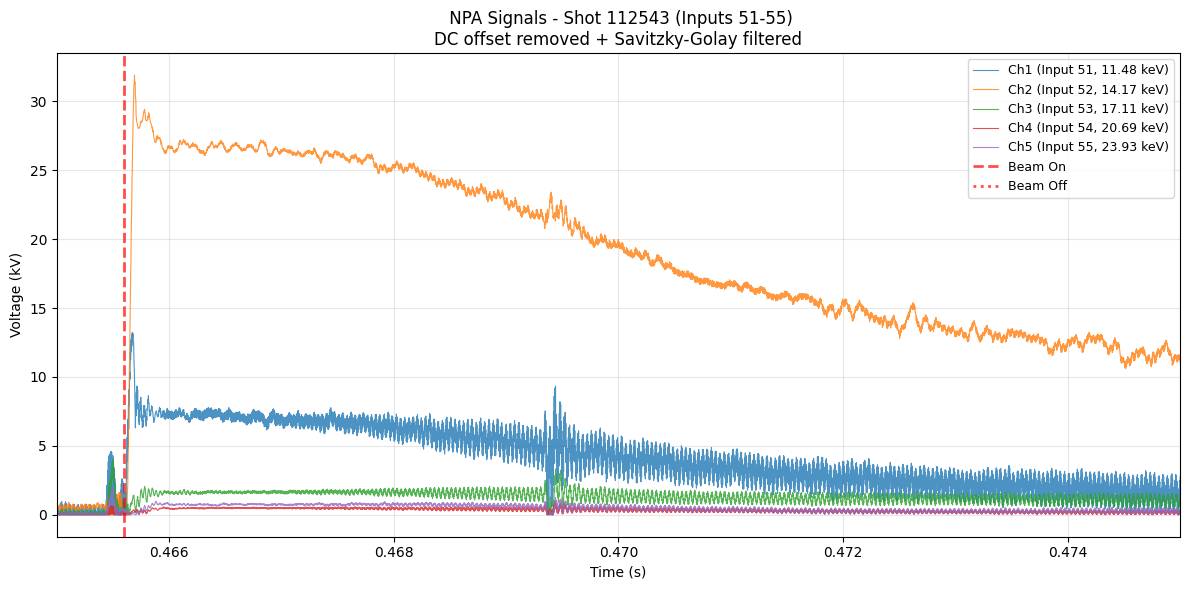

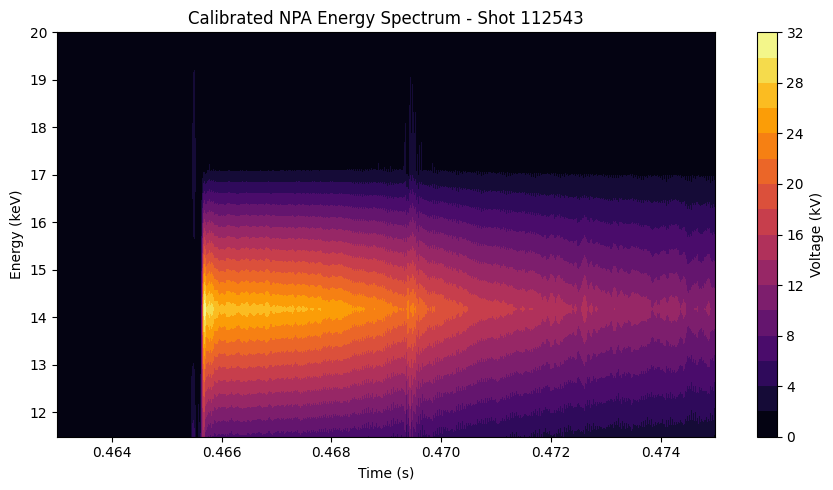

In [5]:
# ↓↓↓ Plot filtered signals for inputs 51-55 on the same axis (same data that goes into contour plot)↓↓↓↓
shot = 112543

# Load data and apply filtering (same as contour plot)
anpa_raw, t_anpa = get_anpa_rawdata(shot)
anpa_filtered = apply_filter(anpa_raw, t_anpa, baseline_duration=0.001)  # DC offset removed + filtered

# Calibration factors
rel_cal = [0.1, 0.389, 0.56, 1.000, 0.955, 1.177, 1.212, 1.065, 1.106, 0.502]

# Apply calibration to filtered data
for i in np.arange(10):
    anpa_filtered[i, :] /= rel_cal[i]

# Get beam timing for reference
conn = MDSplus.Connection('lithos.pppl.gov:8000')
conn.openTree('ltx_b', shot)
if shot > 200000:
    v_node = r'\ltx_nbi::top.source_diags:v_hvps'
else:
    v_node = r'\ltx_b::top.oper_diags.ltx_nbi.source_diags:v_hvps'
vb = conn.get(v_node).data()
tv = conn.get(f'dim_of({v_node})').data()
conn.closeAllTrees()

beam_mask = vb > 5000
if np.any(beam_mask):
    t_beam_start = tv[beam_mask][0]
    t_beam_end = tv[beam_mask][-1]
    beam_duration = (t_beam_end - t_beam_start) * 1000  # Convert to ms
    print(f"Beam window: {t_beam_start:.6f} - {t_beam_end:.6f} s")
    print(f"Beam duration: {beam_duration:.2f} ms")

# Plot inputs 51-55 (channels 0-4) - FILTERED data
plt.figure(figsize=(12, 6))

channels_to_plot = range(5)  # Channels 0-4 (inputs 51-55)
energies = [11.48, 14.17, 17.11, 20.69, 23.93]  # keV

for i in channels_to_plot:
    label = f'Ch{i+1} (Input {51+i}, {energies[i]:.2f} keV)'
    plt.plot(t_anpa, anpa_filtered[i, :], label=label, linewidth=0.8, alpha=0.8)

# Add vertical lines for beam timing if available
if np.any(beam_mask):
    plt.axvline(t_beam_start, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Beam On')
    plt.axvline(t_beam_end, color='red', linestyle=':', linewidth=2, alpha=0.7, label='Beam Off')

plt.xlabel('Time (s)')
plt.ylabel('Voltage (kV)')
plt.title(f' NPA Signals - Shot {shot} (Inputs 51-55)\nDC offset removed + Savitzky-Golay filtered')
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)
plt.xlim(0.465, 0.475)  # Same time window as energy spectrum
plt.tight_layout()
plt.show()

# Create contour plot with calibrated filtered data
energy, low_energy, high_energy = energy_calibration()

# Use all 10 channels for contour plot
Z = anpa_filtered  # Already filtered and calibrated

plt.figure(figsize=(9, 5))
CS = plt.contourf(t_anpa, energy, Z, levels=20, cmap='inferno')
plt.colorbar(CS, label='Voltage (kV)')

plt.xlabel("Time (s)")
plt.ylabel("Energy (keV)")
plt.title(f"Calibrated NPA Energy Spectrum - Shot {shot}")
plt.xlim(0.463, 0.475)  # Same time window as time traces
plt.ylim(None, 20)  # Show up to 20 keV
plt.tight_layout()
plt.show()

data length: 102400 pts
data length: 102400 pts
Shot 112558: Beam 0.465597 - 0.475797 s (10.20 ms)
Shot 112562: Beam 0.465679 - 0.475799 s (10.12 ms)


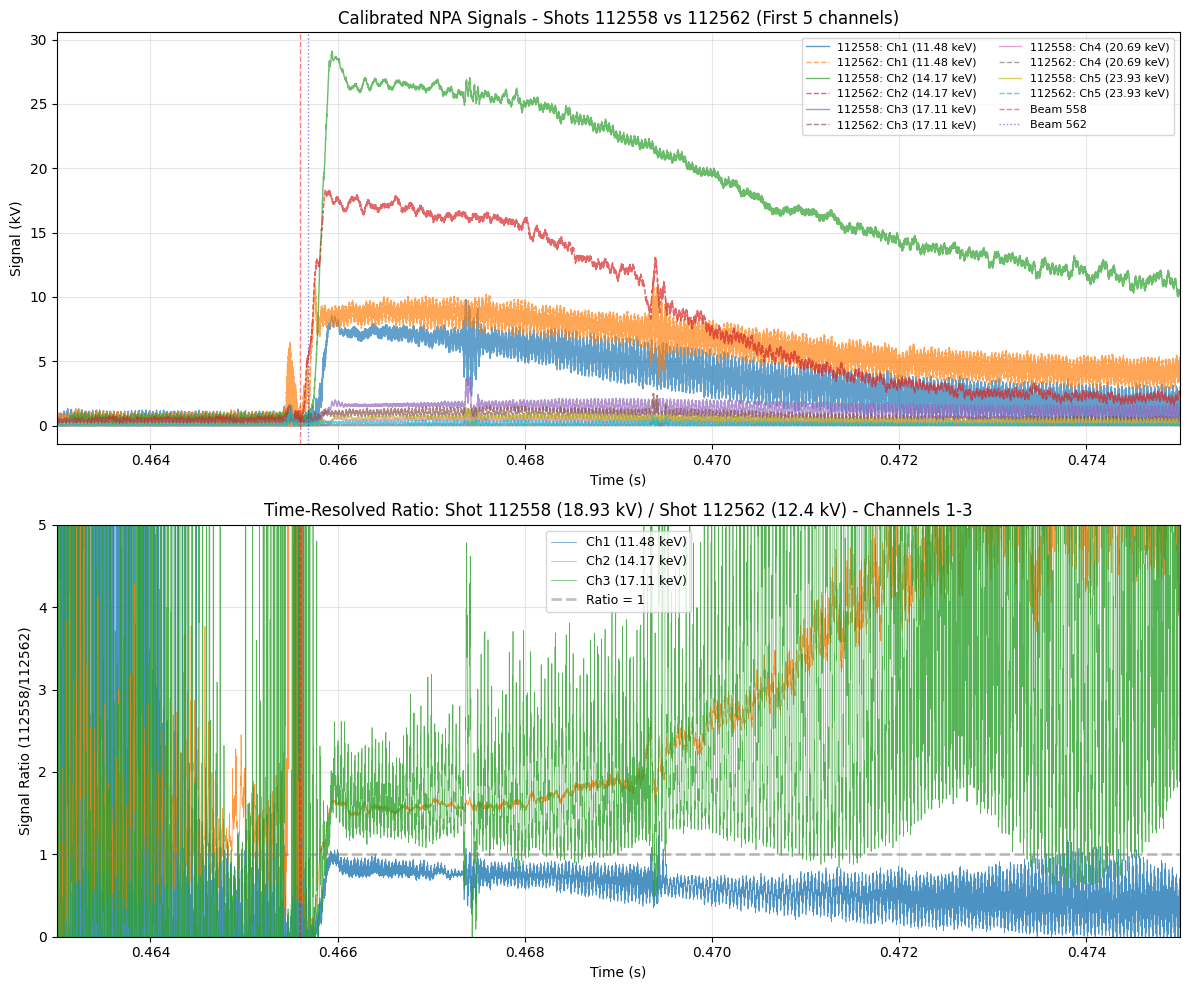


Time-averaged ratios (0.467-0.47 s):
  Ch1 (11.48 keV): 0.708
  Ch2 (14.17 keV): 1.847
  Ch3 (17.11 keV): 178386249.130
  Ch4 (20.69 keV): 1556880839.361
  Ch5 (23.93 keV): 496999232.341
  Ch6 (27.23 keV): 321189718.719
  Ch7 (30.96 keV): 136485061.011
  Ch8 (34.82 keV): 221120435.703
  Ch9 (38.70 keV): 47147822.820
  Ch10 (43.56 keV): 314601458.814

Mean ratio across all channels: 327281082.045
Std deviation of ratio: 436286720.129


In [6]:
# Compare shots 112558 (18.93 kV) and 112562 (12.4 kV) - channel ratios
shot1 = 112558  # Higher beam energy
shot2 = 112562  # Lower beam energy

# Load and process both shots identically
anpa_raw1, t_anpa1 = get_anpa_rawdata(shot1)
anpa_filtered1 = apply_filter(anpa_raw1, t_anpa1, baseline_duration=0.001)

anpa_raw2, t_anpa2 = get_anpa_rawdata(shot2)
anpa_filtered2 = apply_filter(anpa_raw2, t_anpa2, baseline_duration=0.001)

# Calibration factors
rel_cal = [0.1, 0.389, 0.56, 1.000, 0.955, 1.177, 1.212, 1.065, 1.106, 0.502]

# Apply calibration to both shots
for i in np.arange(10):
    anpa_filtered1[i, :] /= rel_cal[i]
    anpa_filtered2[i, :] /= rel_cal[i]

# Get beam timing for shot 1
conn = MDSplus.Connection('lithos.pppl.gov:8000')
conn.openTree('ltx_b', shot1)
v_node = r'\ltx_b::top.oper_diags.ltx_nbi.source_diags:v_hvps'
vb1 = conn.get(v_node).data()
tv1 = conn.get(f'dim_of({v_node})').data()
conn.closeAllTrees()

# Get beam timing for shot 2
conn = MDSplus.Connection('lithos.pppl.gov:8000')
conn.openTree('ltx_b', shot2)
vb2 = conn.get(v_node).data()
tv2 = conn.get(f'dim_of({v_node})').data()
conn.closeAllTrees()

# Find common time window during beam on for both shots
beam_mask1 = vb1 > 5000
beam_mask2 = vb2 > 5000

if np.any(beam_mask1) and np.any(beam_mask2):
    t_start1 = tv1[beam_mask1][0]
    t_end1 = tv1[beam_mask1][-1]
    t_start2 = tv2[beam_mask2][0]
    t_end2 = tv2[beam_mask2][-1]
    
    print(f"Shot {shot1}: Beam {t_start1:.6f} - {t_end1:.6f} s ({(t_end1-t_start1)*1000:.2f} ms)")
    print(f"Shot {shot2}: Beam {t_start2:.6f} - {t_end2:.6f} s ({(t_end2-t_start2)*1000:.2f} ms)")
    
    # Compute ratio time traces for each channel: shot1/shot2
    # Add small epsilon to avoid division by zero
    epsilon = 1e-10
    ratio_traces = np.zeros((10, len(t_anpa1)))
    
    for i in range(10):
        ratio_traces[i, :] = anpa_filtered1[i, :] / (anpa_filtered2[i, :] + epsilon)
    
    # Energy calibration
    energies = np.array([11.48, 14.17, 17.11, 20.69, 23.93, 27.23, 30.96, 34.82, 38.70, 43.56])
    
    # Plot time traces for selected channels
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot 1: Absolute signals for both shots (first 5 channels)
    ax1 = axes[0]
    for i in range(5):
        ax1.plot(t_anpa1, anpa_filtered1[i, :], label=f'{shot1}: Ch{i+1} ({energies[i]:.2f} keV)', 
                 linewidth=1, alpha=0.7)
        ax1.plot(t_anpa2, anpa_filtered2[i, :], '--', label=f'{shot2}: Ch{i+1} ({energies[i]:.2f} keV)', 
                 linewidth=1, alpha=0.7)
    
    ax1.axvline(t_start1, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Beam 558')
    ax1.axvline(t_end1, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax1.axvline(t_start2, color='blue', linestyle=':', linewidth=1, alpha=0.5, label='Beam 562')
    ax1.axvline(t_end2, color='blue', linestyle=':', linewidth=1, alpha=0.5)
    
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Signal (kV)')
    ax1.set_title(f'Calibrated NPA Signals - Shots {shot1} vs {shot2} (First 5 channels)')
    ax1.legend(loc='best', fontsize=8, ncol=2)
    ax1.grid(True, alpha=0.3)
    ax1.set_xlim(0.463, 0.475)
    
    # Plot 2: Ratio time traces (channels 1-3 only)
    ax2 = axes[1]
    for i in range(3):  # Only channels 1-3
        ax2.plot(t_anpa1, ratio_traces[i, :], label=f'Ch{i+1} ({energies[i]:.2f} keV)', 
                 linewidth=0.5, alpha=0.8)
    
    ax2.axhline(y=1, color='gray', linestyle='--', linewidth=2, alpha=0.5, label='Ratio = 1')
    ax2.axvline(t_start1, color='red', linestyle='--', linewidth=1, alpha=0.5)
    ax2.axvline(t_end1, color='red', linestyle='--', linewidth=1, alpha=0.5)
    
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel(f'Signal Ratio ({shot1}/{shot2})')
    ax2.set_title(f'Time-Resolved Ratio: Shot {shot1} (18.93 kV) / Shot {shot2} (12.4 kV) - Channels 1-3')
    ax2.legend(loc='best', fontsize=9)
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0.463, 0.475)
    ax2.set_ylim(0, 5)  # Reasonable range for ratio
    
    plt.tight_layout()
    plt.show()
    
    # Compute time-averaged ratios during beam overlap for summary
    t_window_start = 0.467
    t_window_end = 0.470
    window_mask = (t_anpa1 >= t_window_start) & (t_anpa1 <= t_window_end)
    
    avg_ratios = np.zeros(10)
    for i in range(10):
        avg_ratios[i] = np.mean(ratio_traces[i, window_mask])
    
    print(f"\nTime-averaged ratios ({t_window_start}-{t_window_end} s):")
    for i in range(10):
        print(f"  Ch{i+1} ({energies[i]:5.2f} keV): {avg_ratios[i]:.3f}")
    print(f"\nMean ratio across all channels: {np.mean(avg_ratios):.3f}")
    print(f"Std deviation of ratio: {np.std(avg_ratios):.3f}")
